In [1]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%cd /content/drive/MyDrive/Colab/Transliterate/

/content/drive/MyDrive/Colab/Transliterate


In [3]:
%ls

affidavits.csv  model_plot_dec.png  model_v1.h5                    s2s.h5
model.h5        model.png           players_with_hindi_names.json


# Preprocessing Data

In [4]:
affidavits_df = pd.read_csv('affidavits.csv')

In [5]:
affidavits_df.head()

,address,affidavit_filename_with_unique_id,age,application_uploaded,assembly_constituency,current_status,dropdown_value,fathers_or_husbands_name_english,fathers_or_husbands_name_hindi,name,name_english,name_hindi,party_name,photo_filename_with_unique_id,photo_url,state,unique_id,url
0,"O/5, BANKIM MUKHERJEE SARANI, DURGAPUR COLONY,...",NaN,57,"7th April, 2021",Rashbehari,NaN,NaN,LATE SUBODH CHANDRA DAS,प्रयात सुबोध चन्द्र दास,SWAPAN DAS,SWAPAN DAS,स्वपन दास,Bahujan Mukti Party,NaN,NaN,West Bengal,1,NaN
1,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,2,NaN
2,"Vill- Debidaspur, P.O.- Kankuria, P.S.- Samser...",NaN,60,"26th April, 2021",Samserganj,NaN,NaN,Late Nur Mohammad Biswas,मृत नूर महम्मद बिश्वास,Zaidur Rahaman,Zaidur Rahaman,जैदुर रहमान,Indian National Congress,NaN,NaN,West Bengal,3,NaN
3,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,4,NaN
4,"VILL-FULBARI, P.O-KAMLABARI, P.S-ENGLISH BAZAR...",NaN,42,"6th April, 2021",Manikchak,NaN,NaN,LT. ALI MOHAMMAD,स्वर्गीय आली महममद,ALAM MOTTAKIN,ALAM MOTTAKIN,आलम मोत्ताकिन,Indian National Congress,NaN,NaN,West Bengal,5,NaN


In [6]:
af_df = affidavits_df[['fathers_or_husbands_name_hindi', 'fathers_or_husbands_name_english', 'name_hindi', 'name_english']]

In [7]:
# split and merge
input_target_df = pd.concat([
                    af_df[['fathers_or_husbands_name_hindi','fathers_or_husbands_name_english']].rename(columns={"fathers_or_husbands_name_hindi": "hindi", "fathers_or_husbands_name_english": "english"}), 
                    af_df[['name_hindi','name_english']].rename(columns={"name_hindi": "hindi", "name_english": "english"})
                  ], ignore_index=True)

In [8]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


In [9]:
cricket_df = pd.read_json('players_with_hindi_names.json')

In [10]:
cricket_df.head()

,id,hindi_name,hindi_long_name,english_name,gender,date_of_birth,country_id,slug
0,90143,आर गुरबाज़,रहमानउल्लाह गुरबाज़,Rahmanullah Gurbaz,M,"{'year': 2001, 'month': 11, 'date': 28}",40,rahmanullah-gurbaz
1,54018,एम रिज़वान,मोहम्मद रिज़वान,Mohammad Rizwan,M,"{'year': 1992, 'month': 6, 'date': 1}",7,mohammad-rizwan
2,47686,एस मक़सूद,सोहेब मक़सूद,Sohaib Maqsood,M,"{'year': 1987, 'month': 4, 'date': 15}",7,sohaib-maqsood
3,53649,आर आर रुसो,राइली रुसो,"Rossouw, RR",M,"{'year': 1989, 'month': 10, 'date': 9}",3,rilee-rossouw
4,72393,एस हेटमायर,शिमरॉन हेटमायर,"Hetmyer, SO",M,"{'year': 1996, 'month': 12, 'date': 26}",4,shimron-hetmyer


In [11]:
input_target_df = pd.concat([
                             input_target_df, 
                             cricket_df[['hindi_long_name', 'english_name']].rename(columns={"hindi_long_name": "hindi", "english_name": "english"}) 
                             ], ignore_index=True)

In [12]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


In [13]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33704 entries, 0 to 33703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    28523 non-null  object
 1   english  33704 non-null  object
dtypes: object(2)
memory usage: 526.8+ KB


In [14]:
input_target_df = input_target_df.dropna()

In [15]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28523 entries, 0 to 33703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    28523 non-null  object
 1   english  28523 non-null  object
dtypes: object(2)
memory usage: 668.5+ KB


In [16]:
# strip and make lower case
input_target_df['hindi'] = input_target_df['hindi'].str.strip() # hindi has no caps
input_target_df['english'] = input_target_df['english'].str.strip().str.lower()

In [17]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,late subodh chandra das
1,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
2,मृत नूर महम्मद बिश्वास,late nur mohammad biswas
3,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
4,स्वर्गीय आली महममद,lt. ali mohammad


In [18]:
# Strip out any abbreviated names
input_target_df = input_target_df[~input_target_df['english'].str.contains('\.')]
input_target_df = input_target_df[~input_target_df['english'].str.contains(',')]

In [19]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19697 entries, 0 to 33703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    19697 non-null  object
 1   english  19697 non-null  object
dtypes: object(2)
memory usage: 461.6+ KB


In [20]:
# drop duplicates
input_target_df = input_target_df.drop_duplicates()

In [21]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11745 entries, 0 to 33677
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    11745 non-null  object
 1   english  11745 non-null  object
dtypes: object(2)
memory usage: 275.3+ KB


In [22]:
# Remove if target has non-english 
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

input_target_df = input_target_df[input_target_df['english'].apply(isEnglish)]

In [23]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11692 entries, 0 to 33677
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    11692 non-null  object
 1   english  11692 non-null  object
dtypes: object(2)
memory usage: 274.0+ KB


In [24]:
input_words =  input_target_df['hindi'].tolist()
target_words =  input_target_df['english'].tolist()

In [25]:
print(input_words[0])
print(target_words[0])

प्रयात सुबोध चन्द्र दास
late subodh chandra das


In [26]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 11692
Total number of target words 11692


In [27]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [28]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [29]:
# append start of word (^) and end of word tokens ($)
target_vocab.add('^')
target_vocab.add('$')

In [30]:
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")

Total hindi characters 185
Total english characters 35


In [31]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

In [32]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [33]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [34]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])
# for start & end of the word
max_decoder_seq_length += 1

In [35]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 11692
Number of unique input tokens: 185
Number of unique output tokens: 35
Max sequence length for inputs: 47
Max sequence length for outputs: 48


In [36]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [37]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (11692, 47, 185)
decoder input shape (11692, 48, 35)
decoder target shape (11692, 48, 35)


In [38]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0

  target_text_w_sow = '^' + target_text 
  for t, char in enumerate(target_text_w_sow):
    decoder_input_data[i, t, target_token_index[char]] = 1.0

  target_text_w_eow = target_text + '$'
  for t, char in enumerate(target_text_w_eow):
    decoder_target_data[i, t, target_token_index[char]] = 1.0

# Define Model

In [39]:
latent_dim = 256  # Latent dimensionality of the encoding space.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [40]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [41]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

In [42]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [43]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 185)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 35)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 452608      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  299008      input_2[0][0]                    
                                                                 lstm[0][1]                   

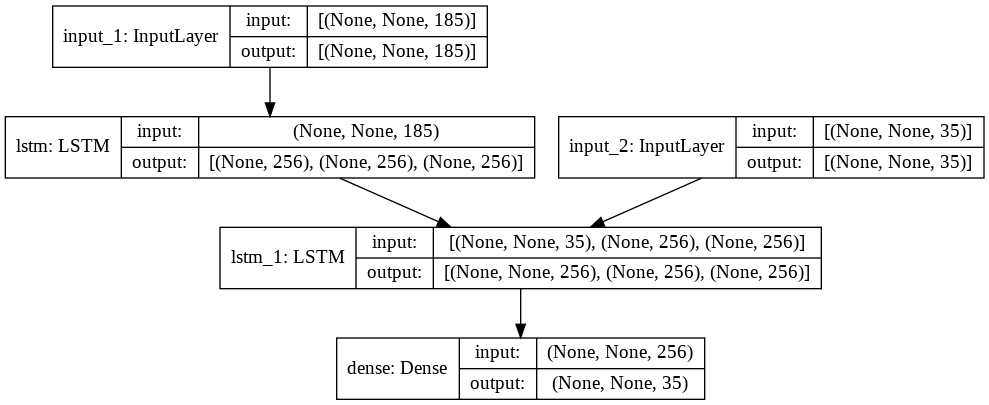

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Train

In [46]:
# Training
batch_size = 32  # Batch size for training.
epochs = 500  # Number of epochs to train for.
initial_learning_rate = 0.001

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=50, 
    restore_best_weights=True)

mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename, 
    monitor="val_accuracy", 
    mode="max",
    verbose=1,
    save_best_only=True
)
lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

Epoch 1/500
293/293 [==============================] - 7s 15ms/step - loss: 0.8852 - accuracy: 0.0588 - val_loss: 0.9014 - val_accuracy: 0.0583

Epoch 00001: val_accuracy improved from -inf to 0.05830, saving model to model.h5
Epoch 2/500
293/293 [==============================] - 3s 12ms/step - loss: 0.8413 - accuracy: 0.0681 - val_loss: 0.8407 - val_accuracy: 0.0702

Epoch 00002: val_accuracy improved from 0.05830 to 0.07016, saving model to model.h5
Epoch 3/500
293/293 [==============================] - 4s 12ms/step - loss: 0.8063 - accuracy: 0.0746 - val_loss: 0.8169 - val_accuracy: 0.0724

Epoch 00003: val_accuracy improved from 0.07016 to 0.07239, saving model to model.h5
Epoch 4/500
293/293 [==============================] - 3s 12ms/step - loss: 0.7837 - accuracy: 0.0789 - val_loss: 0.8001 - val_accuracy: 0.0767

Epoch 00004: val_accuracy improved from 0.07239 to 0.07665, saving model to model.h5
Epoch 5/500
293/293 [==============================] - 3s 12ms/step - loss: 0.7661 

In [47]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


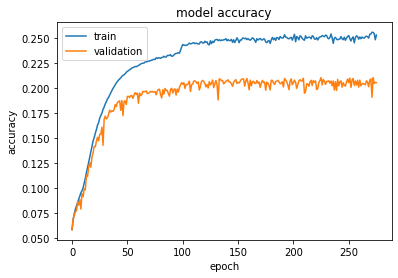

In [48]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

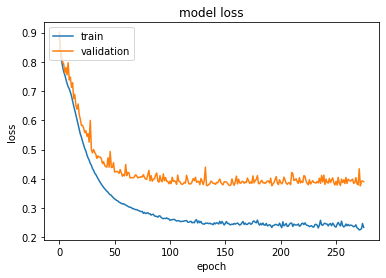

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
%ls -ltr

total 21532
-rw------- 1 root root 3898148 Sep 14 19:57 affidavits.csv
-rw------- 1 root root  813709 Sep 14 22:38 players_with_hindi_names.json
-rw------- 1 root root 5006688 Sep 17 01:54 s2s.h5
-rw------- 1 root root   33396 Sep 19 15:55 model_plot_dec.png
-rw------- 1 root root 6128992 Sep 19 21:17 model_v1.h5
-rw------- 1 root root   36520 Sep 19 22:03 model.png
-rw------- 1 root root 6128992 Sep 19 22:17 model.h5


In [51]:
!du -sh model.h5

5.9M	model.h5


# Inference

In [52]:
# Restore the model and construct the encoder and decoder.
model = load_model(model_save_filename)

In [53]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [54]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

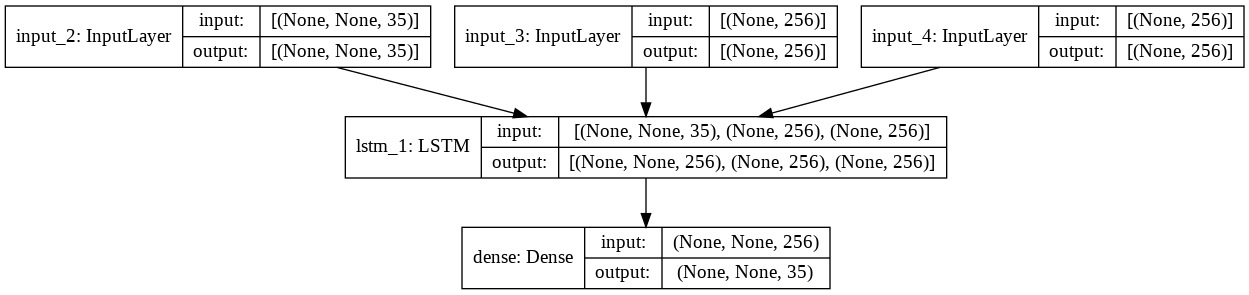

In [55]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [56]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [59]:
test_input = 'राजशेखर'
predicted_string = predict_target(test_input)
predicted_string

'rajashkar'

In [58]:
test_input = 'शारजील'
predicted_string = predict_target(test_input)
predicted_string

'saraver'